<a href="https://colab.research.google.com/github/mxpoch/PCF/blob/main/PCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# key words:
# savings = constant
# none = reserved for root parent

In [1]:
# authentication
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [194]:
# importing
import pandas as pd
import math
import matplotlib.pyplot as plt
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1X4ahQA0pLWN3dd4X64pKShYLzDhvdM3frwBqAY7FfXY/edit?usp=sharing')

read_inputnodes = wb.worksheet('InputNodes').get_all_values()
read_indextree = wb.worksheet('IndexTree').get_all_values()

raw_inputnodes = pd.DataFrame(read_inputnodes[1:], columns=read_inputnodes[0])
# gspread imports everything as string, converting value and timeframe columns to numeric
raw_inputnodes = raw_inputnodes.drop(columns=['value', 'period', 'percent']).join(raw_inputnodes[['value', 'period', 'percent']].apply(pd.to_numeric))

raw_indextree = pd.DataFrame(read_indextree[1:], columns=read_indextree[0])

In [195]:
raw_inputnodes

,name,startdate,enddate,parent,ratetype,value,period,percent
0,rent,01012021,01012022,tuition&fees,linear,-6392,120,0
1,sci_fees,01012021,01012022,tuition&fees,linear,-8,30,0
2,food,01012021,01012022,root,linear,-40,1,0
3,shoes,01012021,01012022,money,constant,-900,1,0
4,debt,01012021,01012022,money,compound,-400,5,70
5,job,1012021,1012022,money,linear,15,1,0


In [235]:
class IndexTree:
    def __init__(self, raw_indextree:pd.DataFrame(), raw_inputnodes:pd.DataFrame()): 
        # print(raw_indextree)
        self.indexdict = self.build_index_tree(raw_indextree, raw_inputnodes)
        self.valuedict = self.build_input_nodes(raw_inputnodes)
        self.daymonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    def build_input_nodes(self, raw_inputnodes:pd.DataFrame()) -> dict:
        retdict = {}
        for i in range(raw_inputnodes.shape[0]):
            current = raw_inputnodes.iloc[i]
            retdict[current['name'].replace(' ', '')] = {col:current[col] for col in current.index if col != 'name'}
        return retdict

    def build_index_tree(self, raw_indextree:pd.DataFrame(), raw_inputnodes:pd.DataFrame()) -> dict:
        retdict = {}
        for i in range(raw_indextree.shape[0]):
            current = raw_indextree.iloc[i]
            children = raw_indextree[raw_indextree['parent'] == current['name']]
            node_children = raw_inputnodes[raw_inputnodes['parent'] == current['name']]
            
            if children.shape[0] == 0 and node_children.shape[0] == 0:
                retdict[current['name']] = 0
                continue

            children = children['name'].tolist()+node_children['name'].tolist()
            retdict[current['name']] = list(map(lambda x: x.strip(), children)) #cleans up any mistaken spaces
        
        return retdict    
    
    def compoundrate(self, name:str, timeframe:int) -> float:
        return self.valuedict[name]['value'] * ( (1 + self.valuedict[name]['percent']*0.01)**(timeframe/self.valuedict[name]['period']) -1 ) + self.valuedict[name]['value']

    def calculaterate(self, name:str, timeframe:int) -> float:
        ratetype = self.valuedict[name]['ratetype']
        if ratetype == 'linear':
            return self.linear_rate(name, timeframe)
        if ratetype == 'constant':
            return self.valuedict[name]['value']
        if ratetype == 'compound':
            return self.compoundrate(name, timeframe)
        else:
            return 0

    def find_timeframe(self, startdate:str, enddate:str) -> int:
        startday = sum(self.daymonth[:int(startdate[:2])-1]) + int(startdate[2:4])
        endday = sum(self.daymonth[:int(enddate[:2])-1]) + int(enddate[2:4]) + (365*(int(enddate[4:])-int(startdate[4:])))
        return endday-startday

    def find_overlap_time(self, date:str, name:str) -> int:
        # checks for overlap with the current date
        # maximum value
        localframe = self.find_timeframe(self.valuedict[name]['startdate'], self.valuedict[name]['enddate'])
        currentday = self.find_timeframe(self.valuedict[name]['startdate'], date)
        if currentday < 0 or currentday > localframe: return -1
        else: return currentday

    def sum_all_worker(self, name:str, currentsum:list, date:str):
        if name not in self.indexdict.keys():
            timeframe = self.find_overlap_time(date, name)
            if timeframe != -1: currentsum[0] += round(self.calculaterate(name, timeframe), 2)
            return 

        for next in self.indexdict[name]:
            self.sum_all_worker(next, currentsum, date)
    
    def sum_all(self, name:str, date:str) -> int:
        currentsum = [0] # necessary to pass by reference in python
        self.sum_all_worker(name, currentsum, date)
        return round(float(currentsum[0]), 2)

    def linear_rate(self, name:str, timeframe:int) -> int:
        return self.valuedict[name]['value']*(timeframe/self.valuedict[name]['period'])

    def pretty_worker(self, name:str, recurdepth:int):
        if name not in self.indexdict.keys(): 
            print("   "*recurdepth, name, '|',self.valuedict[name]['ratetype'])
            return 
        print("   "*recurdepth, name)
        for next in self.indexdict[name]:
            self.pretty_worker(next, recurdepth+1)
    
    def pretty_print_index(self):
        print('Nodes per Month:')
        self.pretty_worker('root', 0) 

    def positive_floor(self, number:int) -> int:
        if number < 0: return -1
        else: return number

    def date_increment(self, date:str, increment:int) -> str:
        # convert whole thing into days since start, then convert back
        # day 0 is new year's day of current year
        currentday = sum(self.daymonth[:(int(date[:2])-1)]) + int(date[2:4])
        currentday += increment

        yeardisplacement = math.floor(currentday/365)
        currentday = currentday % 365

        year = int(date[4:]) + yeardisplacement
        month = 1
        day = 1
        if currentday <= 31:
            day = currentday
        else:
            # is there a better way to do this?
            minmonths = list(filter(lambda x: x >= 0, [currentday-sum(self.daymonth[:x]) for x in range(1,13)]))
            lmin = -1
            for min in minmonths:
                if min < lmin or lmin == -1:
                    lmin = min
                    month += 1
                else: break 
            day = lmin
            
        if month < 10: month = '0'+str(month)
        if day < 10: day = '0'+str(day)

        return str(month)+str(day)+str(year)
    
    def generate_dates(self, startdate:str, enddate:str) -> list:
        cday = self.date_increment(startdate, -1)
        max = self.find_timeframe(cday, enddate)
        for x in range(max):
            cday = self.date_increment(cday, 1)
            yield cday

    def visualize_range(self, sections:list, startdate:str, enddate:str, timeskip:int):
        datapoints = [[] for s in range(len(sections))]
        dates = [t for t in self.generate_dates(startdate, enddate)]
        
        plt.figure(figsize=(10,5))
        i = 0
        for section in sections:
            for t in self.generate_dates(startdate, enddate):
                datapoints[i].append(self.sum_all(section, t))
            plt.plot(dates, datapoints[i], label=section)
            i += 1
        
        title = sections[0]
        if len(sections) > 1: title = ' and '.join(sections)
        plt.title(title)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

In [236]:
IT = IndexTree(raw_indextree, raw_inputnodes)

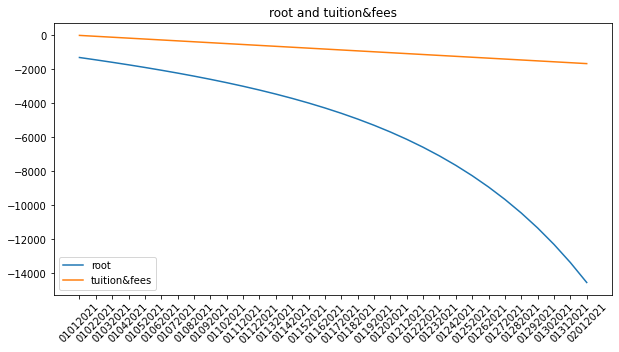

In [239]:
IT.visualize_range(['root', 'tuition&fees'], '01012021', '02012021', 1)

In [240]:
IT.pretty_print_index()

Nodes per Month:
 root
    money
       tuition&fees
          rent | linear
          sci_fees | linear
       shoes | constant
       debt | compound
       job | linear
    food | linear
